# Personalizovani PageRank algoritam primenjen na proteinske interakcije

## Pretprocesiranje

U ovoj svesci bice pokazana primena PageRank algoritma na interakciju viralnih proteina enkodiranih od strane SARS-CoV-2. Korisceni podaci se nalaze u okviru direktorijuma `COVID_19_PPI`, a najnoviji azurirani podaci mogu se skinuti [ovde](https://downloads.thebiogrid.org/File/BioGRID/Latest-Release/BIOGRID-PROJECT-covid19_coronavirus_project-LATEST.zip).

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

BioGRID (sajt sa koga su podaci preuzeti) [ovako](https://wiki.thebiogrid.org/doku.php/biogrid_tab_version_3.0) opisuje format `tab3` datoteka.

In [2]:
file_name = 'COVID_19_PPI/BIOGRID-PROJECT-covid19_coronavirus_project-INTERACTIONS-4.4.210.tab3.txt'
df = pd.read_csv(file_name, sep='\t')
df.head()

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,2652341,43740570,8546,4383845,114116,GU280_gp04,-,E,AP3B1,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,-,NP_001258698|NP_003655,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
1,2652342,43740570,23476,4383845,117036,GU280_gp04,-,E,BRD4,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,-,NP_001317313|NP_490597|NP_001366221|NP_0013662...,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
2,2652343,43740570,6046,4383845,111973,GU280_gp04,DADB-17J1.3,E,BRD2,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,X5CF57|A0A024RCR5,NP_001186384|NP_005095|NP_001278915|NP_0011066...,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
3,2652344,43740570,10283,4383845,115572,GU280_gp04,UNQ438/PRO871,E,CWC27,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,D6REK3,NP_001284574|NP_005860|NP_001351407|NP_0013049...,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
4,2652345,43740570,124245,4383845,125858,GU280_gp04,-,E,ZC3H18,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,B4DTK7|E7ERS3,NP_653205|NP_001281269,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens


In [3]:
df.shape

(29716, 37)

Podaci su preprocesirani na sledeci nacin:
1. preimnovana je prva kolona da ne sadrzi `#` na pocetku
1. vrednosti `-` su zamenjene sa `np.nan` zbog lakseg rukovanja
1. odbaceni su redovi koji sadrze nedostajuce vrednosti
1. odbacene su kolone koje sadrze nedostajuce vrednosti

In [4]:
df.rename(mapper=lambda col: col.lstrip('#'), axis=1, inplace=True)
df = df.applymap(lambda x: np.nan if x == "-" else x)
df.dropna(subset=['Entrez Gene Interactor A', 'Entrez Gene Interactor B'], inplace=True)
df.dropna(axis=1, inplace=True)
df.head()

,BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Experimental System,Experimental System Type,Author,Publication Source,Organism ID Interactor A,Organism ID Interactor B,Throughput,Source Database,Organism Name Interactor A,Organism Name Interactor B
0,2652341,43740570,8546,4383845,114116,E,AP3B1,Affinity Capture-MS,physical,Gordon DE (2020),PUBMED:32353859,2697049,9606,High Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
1,2652342,43740570,23476,4383845,117036,E,BRD4,Affinity Capture-MS,physical,Gordon DE (2020),PUBMED:32353859,2697049,9606,High Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
2,2652343,43740570,6046,4383845,111973,E,BRD2,Affinity Capture-MS,physical,Gordon DE (2020),PUBMED:32353859,2697049,9606,High Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
3,2652344,43740570,10283,4383845,115572,E,CWC27,Affinity Capture-MS,physical,Gordon DE (2020),PUBMED:32353859,2697049,9606,High Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
4,2652345,43740570,124245,4383845,125858,E,ZC3H18,Affinity Capture-MS,physical,Gordon DE (2020),PUBMED:32353859,2697049,9606,High Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Homo sapiens


In [5]:
df.shape

(27189, 17)

Odbaceno je 2527 redova i 20 kolona. Odbacene kolone nisu od interesa jer se ne koriste za konstrukciju grafa. Kao identifikatori cvorova, bice korisceni identifikatori gena a simboli ce biti korisceni kao labele. Pokazuje se da simboli gena ne odredjuju jednoznacno konkretan gen. Takodje, kolone `BioGRID ID Interactor {A,B}` su semanticki identicne `Entrez Gene Interactor {A,B}` kolonama. Jedina razlika je sto se koriste za pretrazivanje razlicitih onlajn baza gena. U nastavku bice koriscen samo `BioGRID ID Interactor {A,B}`.

In [6]:
import re

cols = [
    'BioGRID ID Interactor A',
    'BioGRID ID Interactor B',
    'Official Symbol Interactor A',
    'Official Symbol Interactor B'
]

final = pd.DataFrame(data=df[cols].to_numpy(), columns=cols, index=list(df['BioGRID Interaction ID']))
final.rename(columns=lambda col: re.sub(r'^.*(Symbol|ID) Interactor (A|B)$', '\g<1>_\g<2>', col), inplace=True)
print(final.shape)
final.head()

(27189, 4)


,ID_A,ID_B,Symbol_A,Symbol_B
2652341,4383845,114116,E,AP3B1
2652342,4383845,117036,E,BRD4
2652343,4383845,111973,E,BRD2
2652344,4383845,115572,E,CWC27
2652345,4383845,125858,E,ZC3H18


Ovako transformisan skup `final` bice koriscen za dalji rad. Kolone su preimenovane zbog lakseg rukovanja. DataFrame `final` ima indeks koji odgovara `BioGRID Interaction ID` iz inicijalnog skupa podataka.

## Primena PageRank algoritma

Na pocetku se kreira neusmeren graaf koji ce prilikom primene algoritma biti implicitno pretvoren u usmeren graf sa granama u oba smera. Identifikator se koristi kao ime cvora, a simbol se pridruzuje kao dodatna labela. Za svaku granu se dodaje dodatna informacija o identifikatoru interakcije.

In [7]:
G = nx.Graph()

for interaction_id, (id_a, id_b, symbol_a, symbol_b) in final.iterrows():
    G.add_node(id_a, label=symbol_a)
    G.add_node(id_b, label=symbol_b)
    G.add_edge(id_a, id_b, interaction_id=interaction_id)

Zatim se definise funkcija koja ce se koristiti za izracunavanje ocene cvorova. Funkcija `pagerank` vraca `DataFrame` sa kolonama `id`, `symbol` i `score` sa redovima sortiranim po koloni `score`, opadajuce.

In [8]:
def pagerank(G, alpha=0.9, personalization=None, N=20):
    scores = nx.pagerank(G, alpha, personalization=personalization)
    
    scores_sorted = sorted(scores.items(), key=lambda x: x[1], reverse=True)

    node_label = lambda symbol: G.nodes[symbol]['label']

    top = pd.DataFrame(
        [[node, node_label(node), score] for (node, score) in scores_sorted[:N]],
        columns=['id', 'symbol', 'score']
    )
    
    return top

In [9]:
def draw_subgraph(G, top_nodes):
    subg = G.subgraph(list(top_nodes['id']))
    
    pos = nx.circular_layout(subg)
    
    plt.figure(figsize=(30, 30))
    
    get_score = lambda i: top_nodes[top_nodes['id'] == i]['score']
    
    colors = [get_score(node_id) for node_id in subg.nodes()]

    # Iscrtavamo cvorove
    nx.draw_networkx_nodes(subg, pos, cmap=plt.cm.Reds, node_color=colors, node_size=3000, node_shape='h')

    # Iscrtavamo oznake cvorova
    labels = {node: f'{data["label"]}\n({node})' for (node, data) in subg.nodes.items()}
    label_pos = {k: (v[0], v[1]+0.07) for (k, v) in pos.items()}
    nx.draw_networkx_labels(subg, label_pos, labels=labels, font_color='k', font_size=12, font_weight='bold')

    # Iscrtavamo grane
    nx.draw_networkx_edges(subg, pos, edgelist=subg.edges(), width=1, edge_color='lightblue')

    # Iskljucujemo ose
    plt.axis('off')

    # I prikazujemo graf
    plt.show()

### PageRank bez personalizacije

Prvo ce biti primenjen PageRank bez personalizacije. Generisu se i prikazuju dvadeset cvorova najbolje ocenjenih algoritmom

In [10]:
best_nodes = pagerank(G)
best_nodes

,id,symbol,score
0,4383846,M,0.041762
1,4383871,ORF7b,0.036227
2,4383853,nsp4,0.031429
3,4383855,nsp6,0.028170
4,4383868,ORF3a,0.026007
5,4383872,ORF7a,0.025901
6,4383873,ORF8,0.022703
7,4383845,E,0.022646
8,4383848,S,0.018454
9,4383847,N,0.017850


Iscrtavaju se cvorovi dobijeni prethodnim krakom. Tamnije nijanse crvene boje na crtezu prikacuju veci skor.

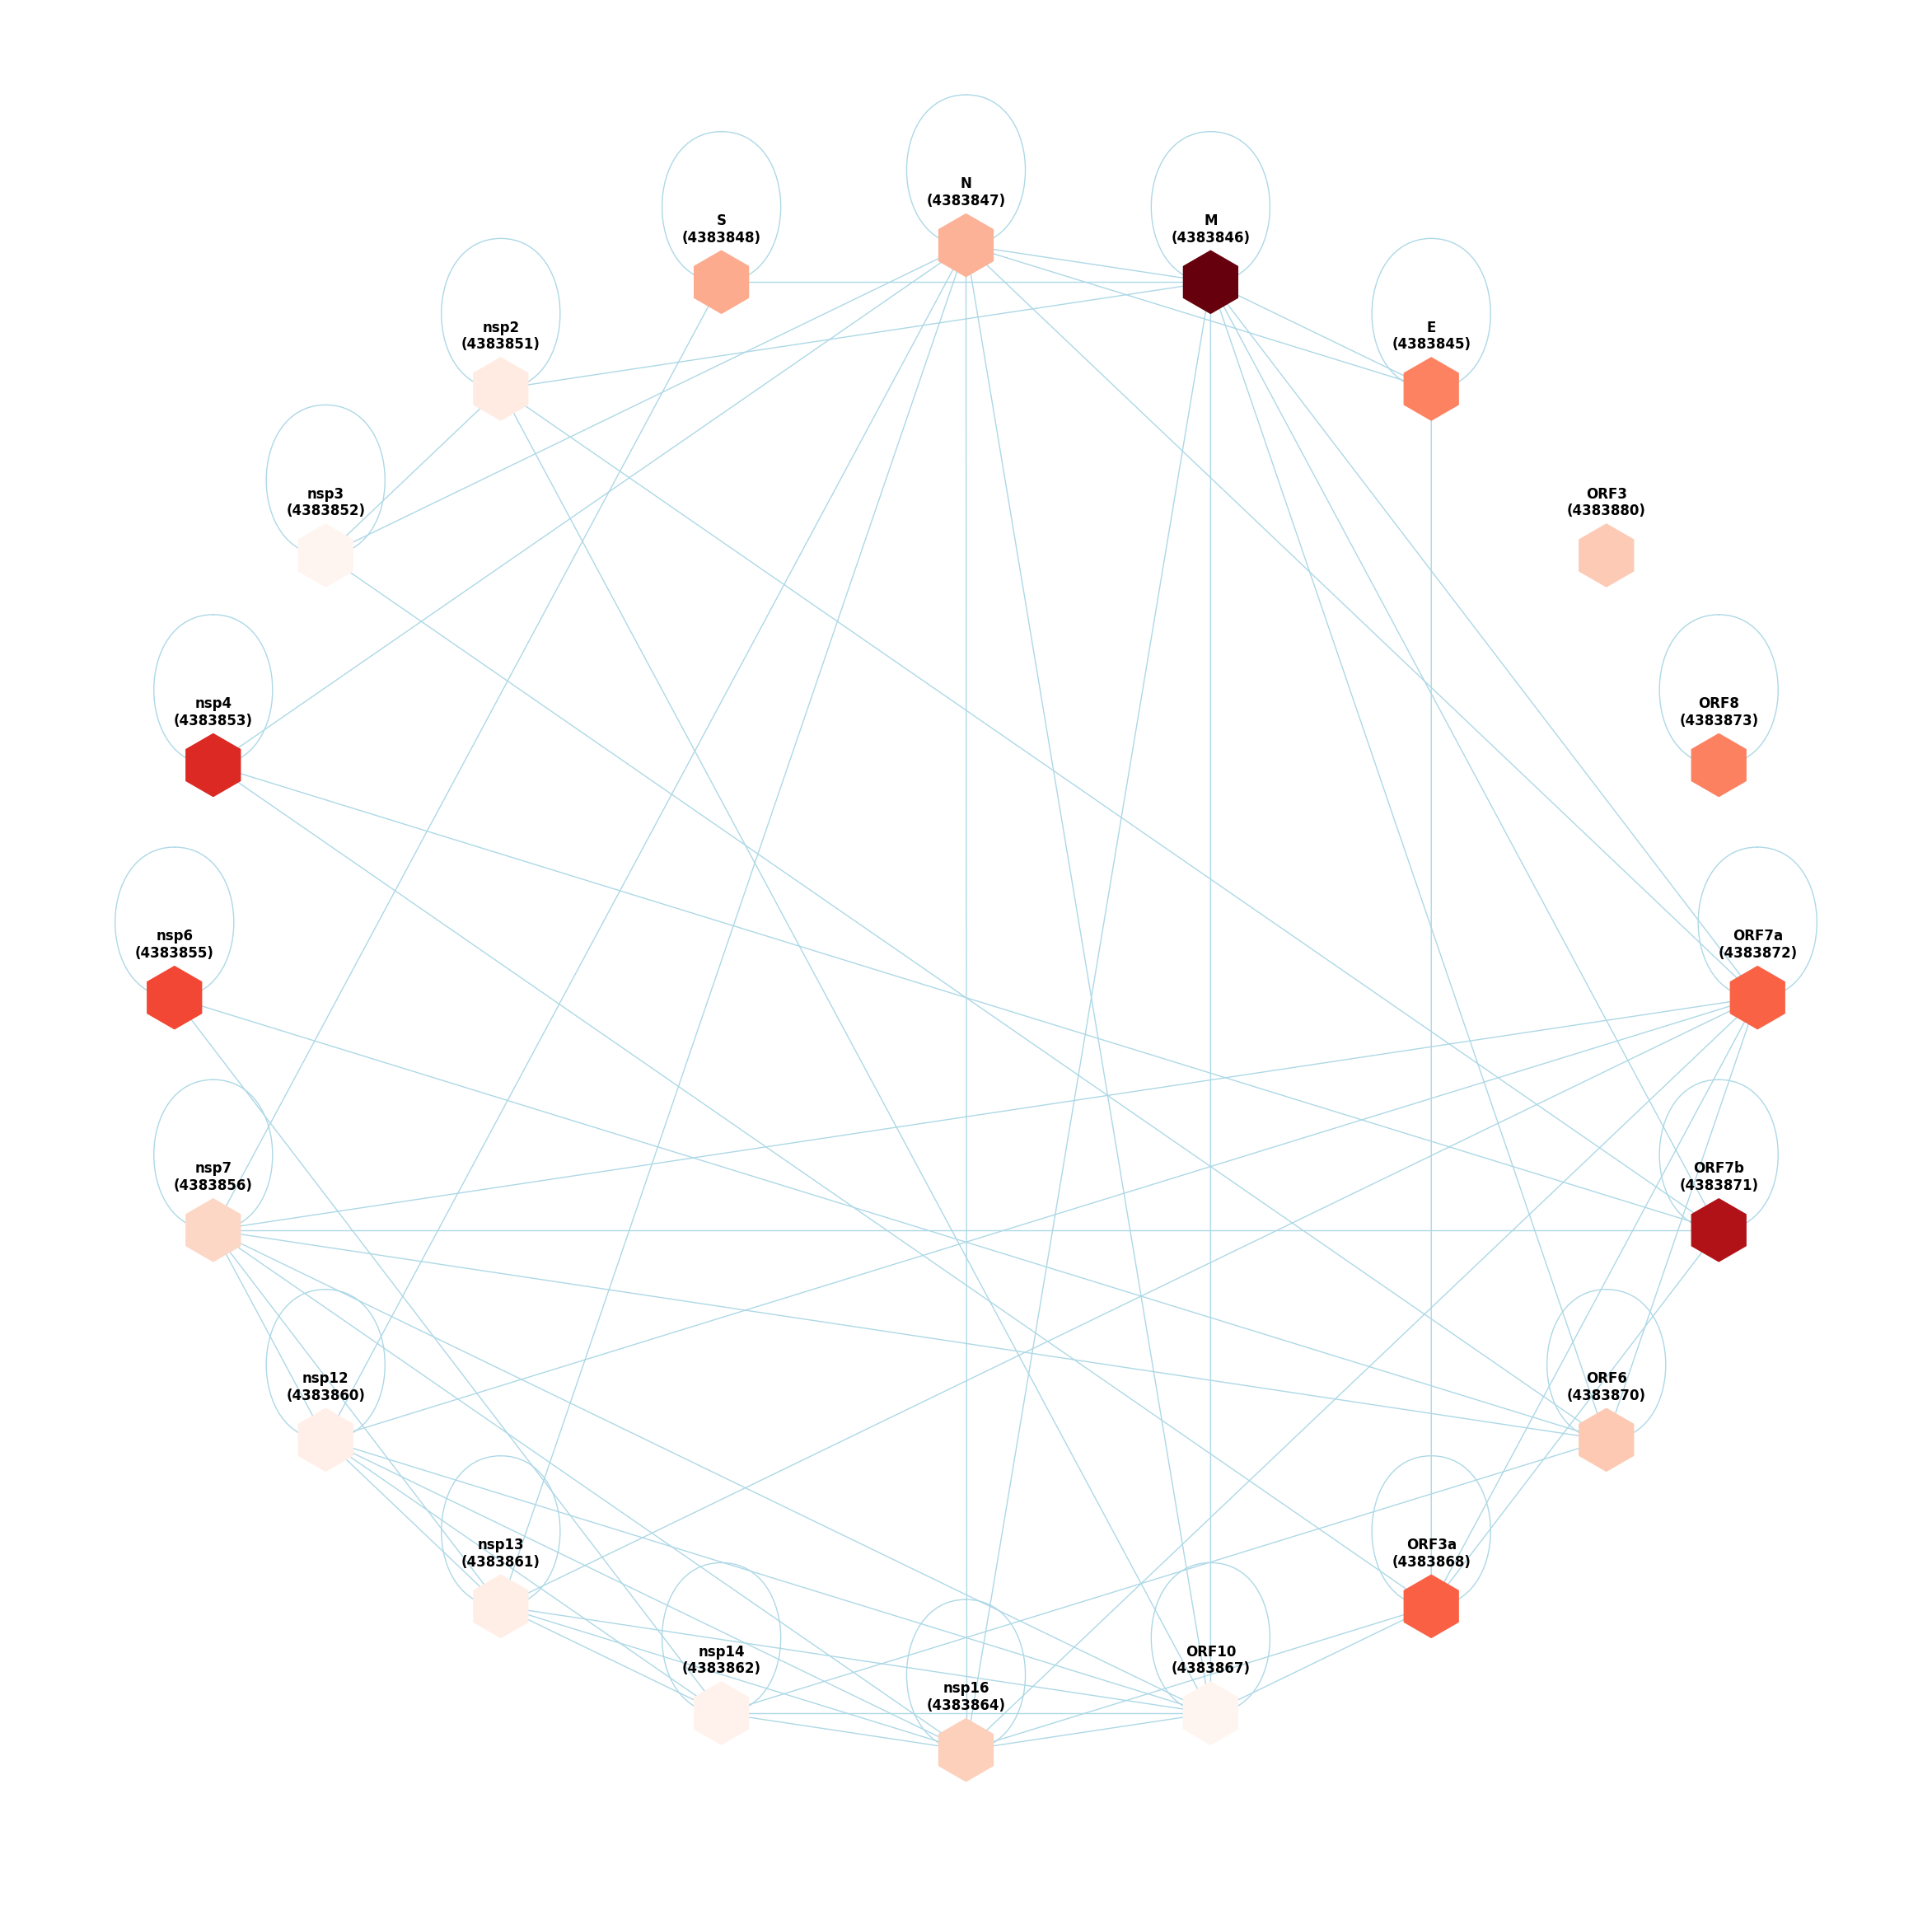

In [11]:
draw_subgraph(G, best_nodes)

### PageRank sa personalizacijom

Pokazace se kako se personalizacijom utice na algoritam tako da cvor sa najmanjim skorom iz prethodne liste proteina (4383867, ORF10, 0.008563) postane cvor sa najvecim skorom. 

In [12]:
node_boost_id = 4383867

low = 0.1 / (len(G.nodes) - 1)
high = 0.9

personalization = {
    node: high if node == node_boost_id else low for node in G.nodes
}

best_personalized_nodes = pagerank(G, personalization=personalization)
best_personalized_nodes

,id,symbol,score
0,4383867,ORF10,0.115359
1,4383846,M,0.034211
2,4383871,ORF7b,0.031602
3,4383853,nsp4,0.027803
4,4383873,ORF8,0.025317
5,4383855,nsp6,0.024756
6,4383872,ORF7a,0.023125
7,4383868,ORF3a,0.023110
8,4383845,E,0.022734
9,4383848,S,0.017567


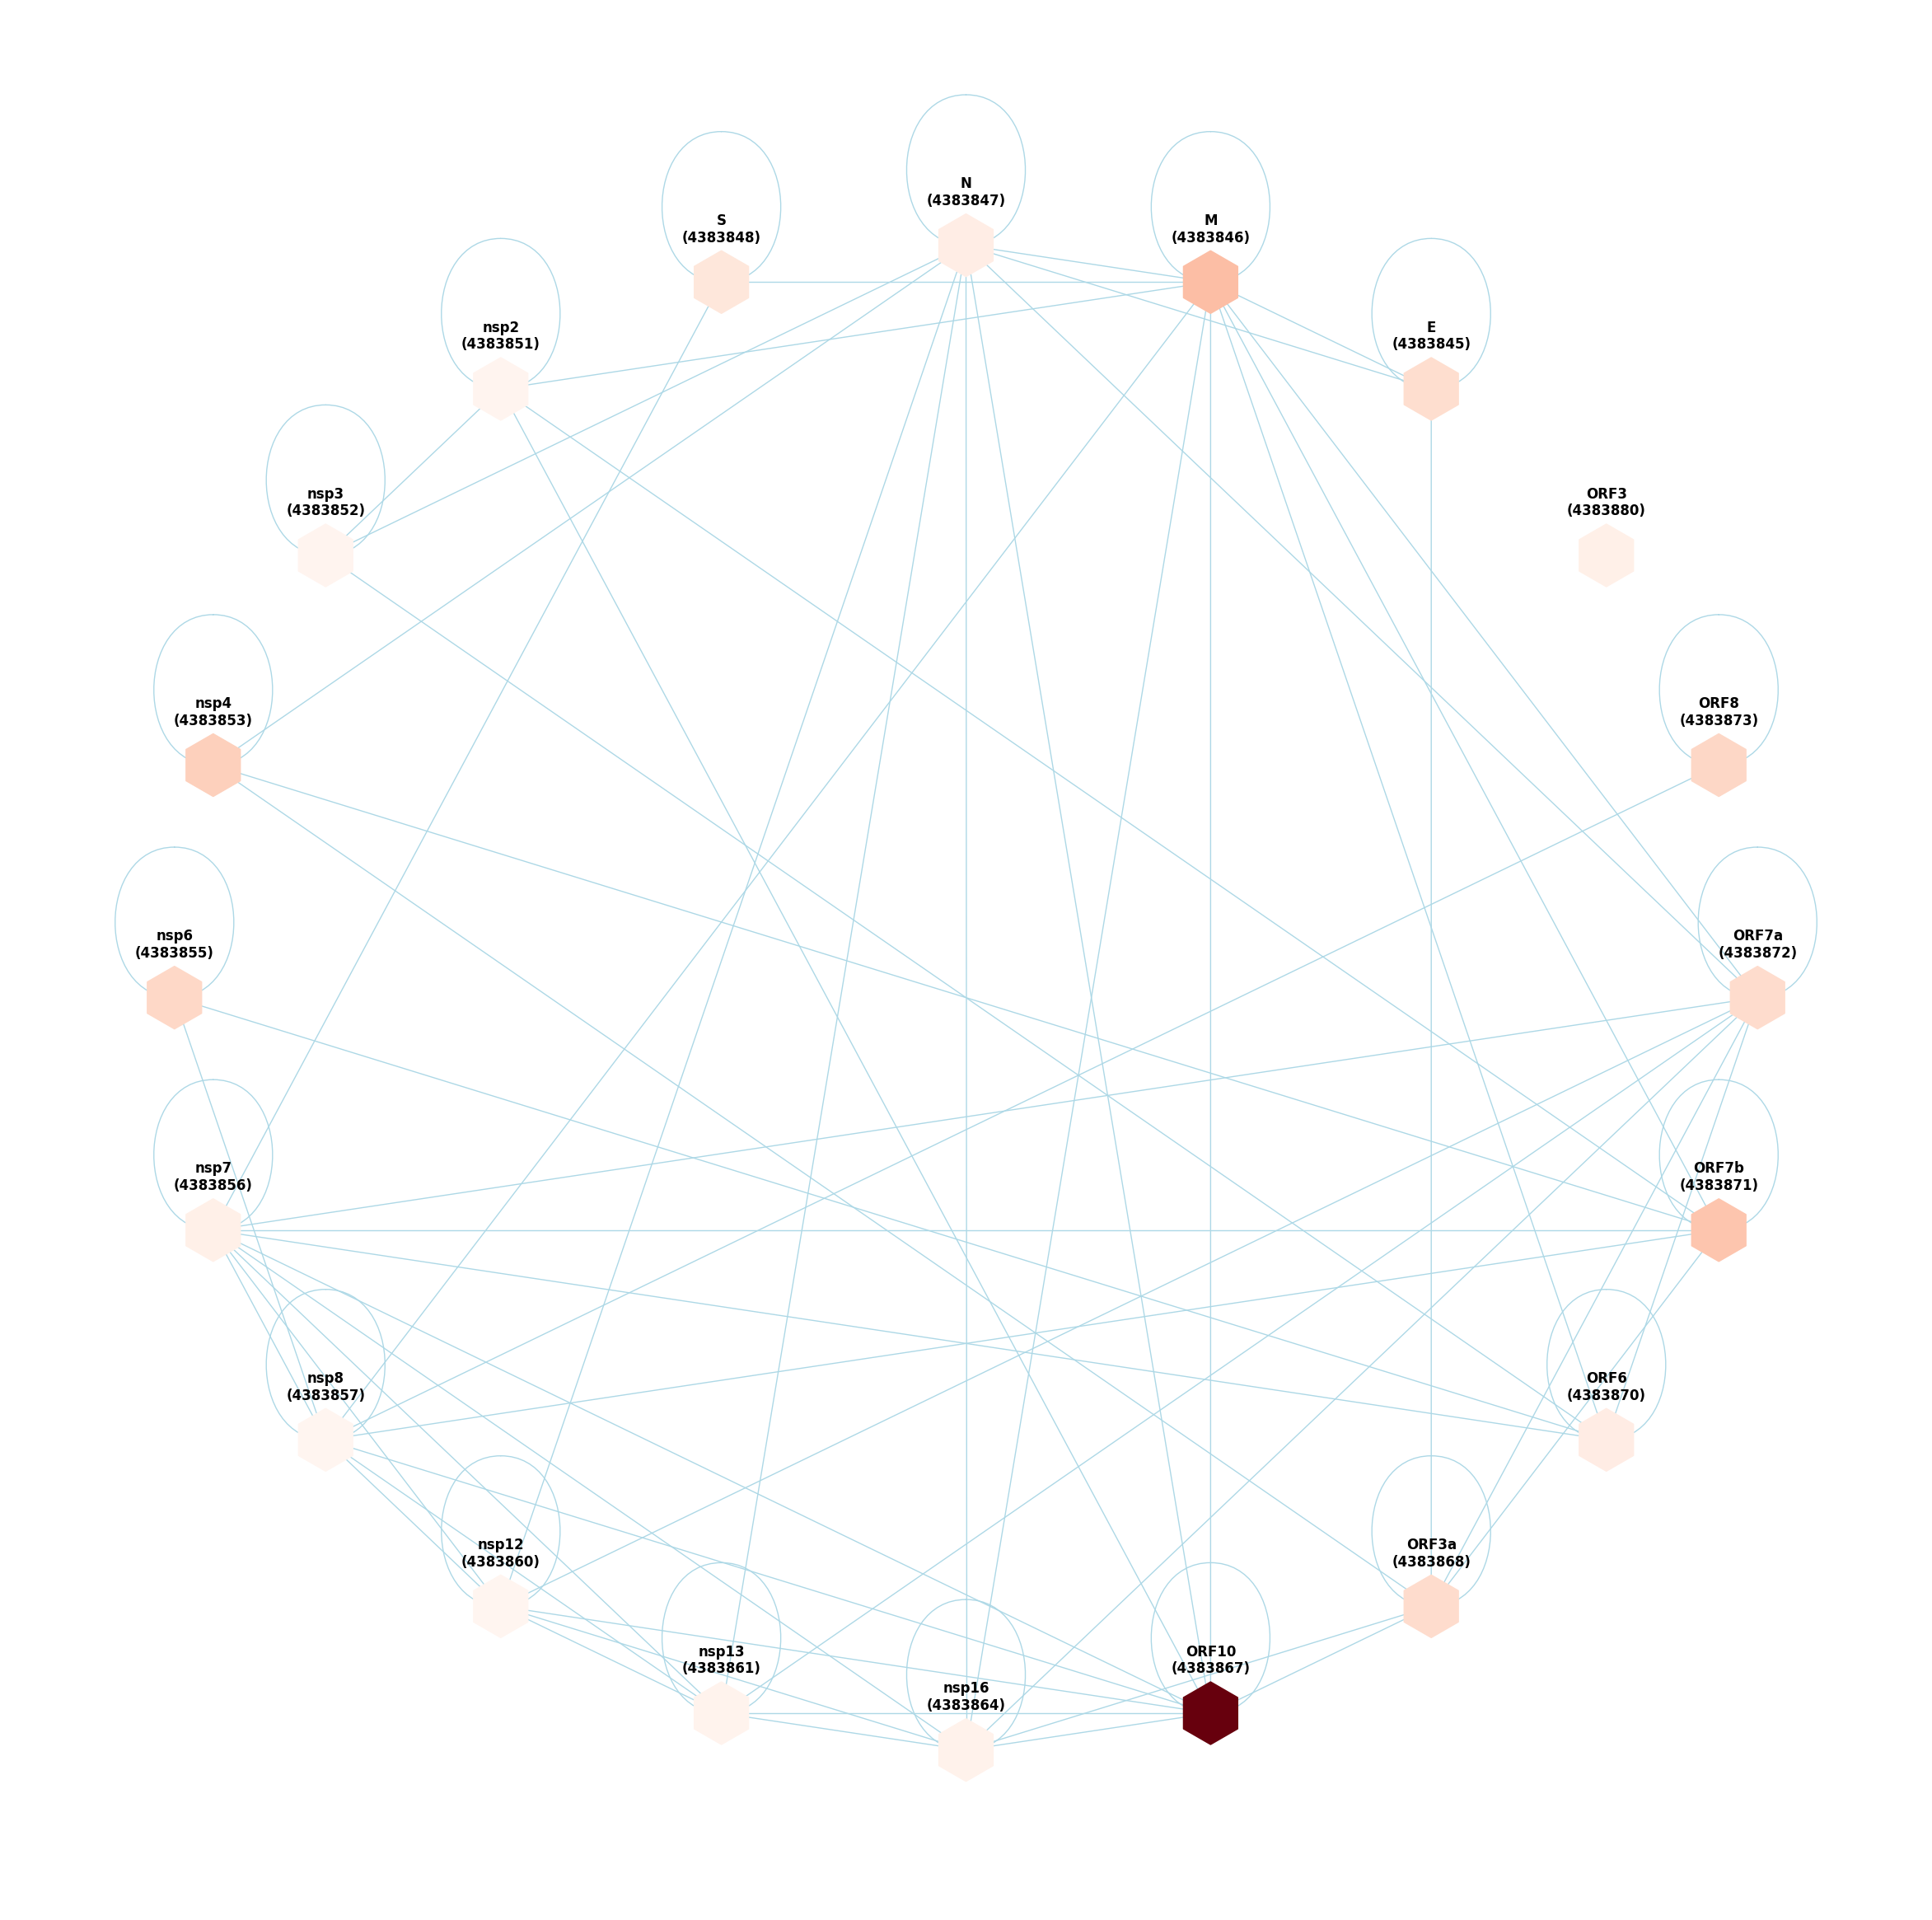

In [13]:
draw_subgraph(G, best_personalized_nodes)

Po izvestaju i po crtezu vidimo da je protein ORF10 ima ubeljivo najveci skor, i ako je bez personalizacije imao najmanji skor.